Project
===

Manually add to path

In [6]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [26]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))
import theano
import theano.tensor as T

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import mode
from utils.mnist_reader import load_mnist
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

%matplotlib inline

Running on PyMC3 v3.5


In [27]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [28]:
X_train.shape

(60000, 28, 28)

In [36]:
# Use tensorflow to 
import tensorflow as tf
reshape_img = lambda img : img.reshape(img.shape[0],-1)
floatX = theano.config.floatX

dataset = 'moon'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_img(X_train),reshape_img(X_test)
    label_dict = {i:str(i) for i in range(10)}
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_img(X_train),reshape_img(X_test)
    label_dict = {0: 'T-shirt/top',
                  1: 'Trouser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle boot'}
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
elif dataset == 'moon':   
    # for moon dataset example
    X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
    X = scale(X)
    X = X.astype(floatX)
    Y = Y.astype(floatX)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.5)

(n_train,n_input) = X_train.shape
n_out = len(label_dict)
print("N Input for {} = {}".format(dataset,n_input))

N Input for moon = 2


In [37]:
set_tt_rng(MRG_RandomStreams(10))

ValueError: cannot reshape array of size 2 into shape (28,28)

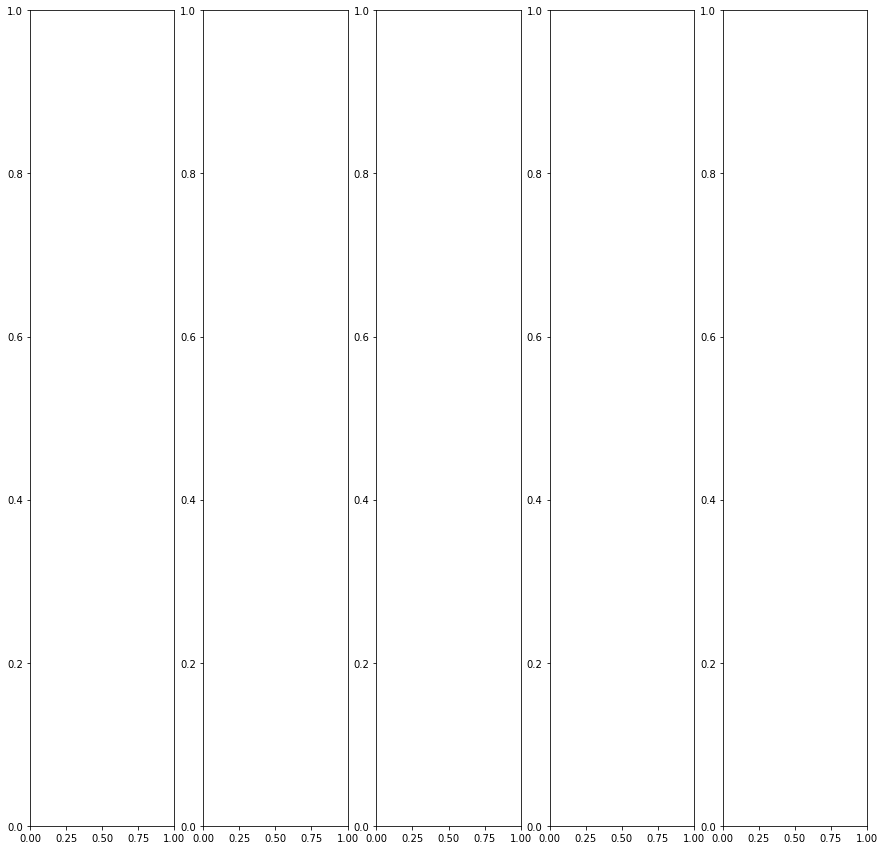

In [38]:
# show a few samples
nsamples = 5
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_train[i],(28,28)),cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(label_dict[y_train[i]])
fig.show()

In [39]:
# now create a simple 3-layer bayesian neural network in pymc3
def construct_nn(ann_input, ann_output):
    n_hidden_1 = 64
    n_hidden_2 = 32
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(n_input, n_hidden_1).astype(floatX)
    init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
    init_out = np.random.randn(n_hidden_2,n_out).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1.2,
                                 shape=(n_input, n_hidden_1),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1.2,
                                shape=(n_hidden_1, n_hidden_2),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1.2,
                                  shape=(n_hidden_2,n_out),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Classification
        out = pm.Categorical('out',
                           act_out,
                           observed=ann_output,
                           total_size=n_train
                          )
    return neural_network

In [40]:
minibatch_x = pm.Minibatch(X_train, batch_size=40)
minibatch_y = pm.Minibatch(y_train, batch_size=40)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(10000, method=inference)

Average Loss = 127.02: 100%|██████████| 10000/10000 [00:10<00:00, 966.66it/s]
Finished [100%]: Average Loss = 126.99


In [41]:
elbo = -inference.hist

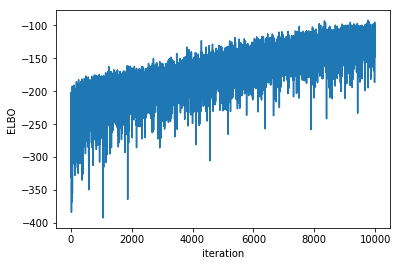

In [42]:
plt.plot(elbo)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.show()

In [43]:
trace = approx.sample(draws=1000)

In [44]:
minibatch_x.set_value(X_test)
minibatch_y.set_value(y_test)
with neural_network_minibatch:
        ppc = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [00:02<00:00, 42.73it/s]


In [45]:
ppc.keys()

dict_keys(['out'])

In [46]:
y_pred = mode(ppc['out'], axis=0).mode[0,:]
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
y_test[0:49]

array([1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.])

ValueError: cannot reshape array of size 2 into shape (28,28)

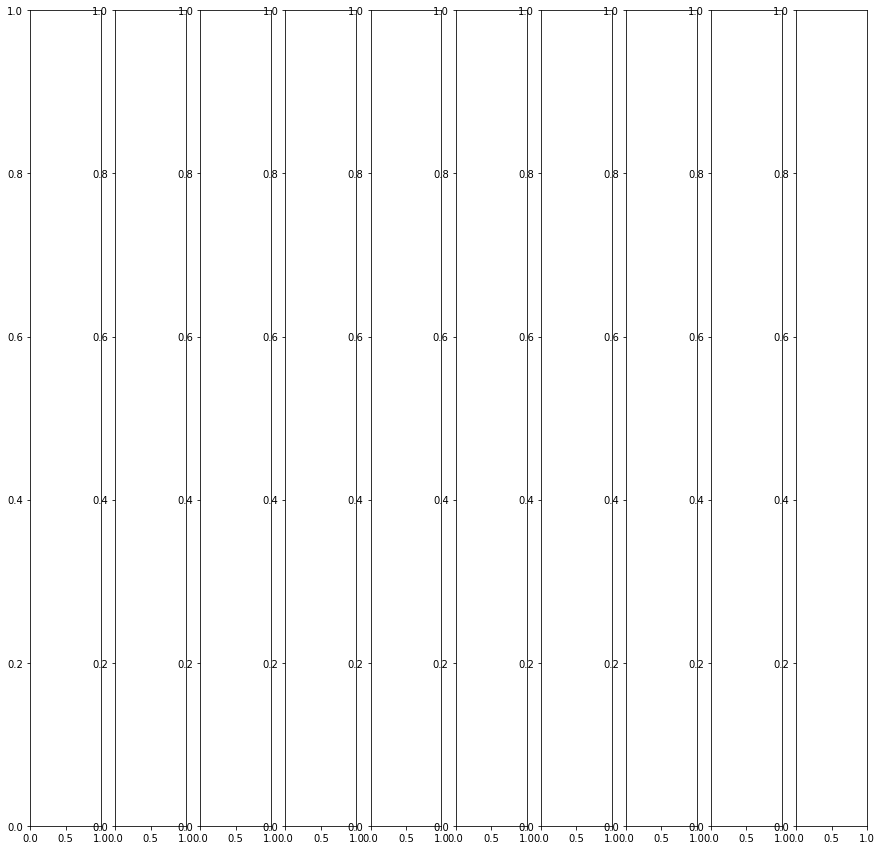

In [48]:
# show a few samples
nsamples = 10
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,nsamples)
for i in range(nsamples):
    ax[i].imshow(np.reshape(X_test[i],(28,28)),cmap='gray')
    ax[i].set_title(label_dict[y_test[i]])
    ax[i].set_xlabel(label_dict[y_pred[i]])
fig.show()